In [1]:
import qcodes as qc
import numpy as np
from time import sleep

import sweep 
from sweep.sweep_load import pload1d
from barreralabdrivers.utils.param_utils import paramp
from cappy.config import DUAL_HEMT_STATION_CONFIG, DATA2_PATH
from cappy.balancer import Balancer

from qcodes.validators import Numbers, Callable, Validator
from qcodes.parameters import Parameter, ScaledParameter
import datetime
from cappy.config import DATA_PATH
from cappy.opener import Opener as Open

In [3]:
qc.Instrument.close_all()   # in case of existing connecitons
container = qc.Station(config_file=str(DUAL_HEMT_STATION_CONFIG))

acdac = container.load_instrument("acdac")
dcdac = container.load_instrument("dcdac")
yoko = container.load_instrument("yoko")
keithley = container.load_instrument("keithley")
li1 = container.load_instrument("lockin")

print(100 * "-")
print(f"{datetime.datetime.now().strftime('%c')}")

Connected to: BARRERA ACDAC02 (serial:AD9106, firmware:2.00) in 3.05s
Connected to: BARRERA DCDAC01 (serial:AD5764, firmware:2.00) in 3.05s
Connected to: YOKOGAWA 765611 (serial:90ZC43353, firmware:1.10) in 0.03s
Connected to: KEITHLEY INSTRUMENTS DMM6500 (serial:04608216, firmware:1.7.12b) in 0.01s
Connected to: Stanford_Research_Systems SR865A (serial:005296, firmware:V1.51) in 0.12s
----------------------------------------------------------------------------------------------------
Fri Mar 21 18:19:42 2025


In [4]:
# Applied AC Voltages
Vref = acdac.ch1
V1pf = acdac.ch2
Vlref = acdac.ch4

# Applied DC Voltages
Vdd = yoko.channel1.voltage             # drives drain to source current across HEMT_A 
Vgamp = dcdac.channel1.voltage          # drives drain to source current across HEMT_R draining at HEMT_A gate 
Vgres = yoko.channel2.voltage           # gate voltage on HEMT_R 


# validators
non_positive_validator = Numbers(min_value=-2 , max_value=0)      
vg_max_validator = Numbers(min_value = -2, max_value=Vgamp.get())

# Vgamp < 0 and Vgres < Vgramp at all times 
Vgamp.add_validator(non_positive_validator)  
Vgres.add_validator(vg_max_validator)

# Measured Quantities 
Vdsdc = keithley.amplitude
Vdsac_R = li1.R
Vdsac_P = li1.P

In [5]:
sweep.set_basedir(DATA2_PATH)

In [6]:
def biasStationFactory(comment=""):
    indep_params= [Vgamp]
    dep_params = [Vdsdc,Vdsac_R, Vdsac_P]

    mc = {}
    for param in indep_params + dep_params:
        mc[param.full_name] = param.label

    s = sweep.Station(basedir=DATA2_PATH,measurement_config=mc)
    for param in indep_params + dep_params:
        s.fp(param)

    s.add_comment(comment)

    for dep in dep_params:
        s.plot(Vgamp, dep)

    return s

In [7]:
def sys_paramp():
    print("Ramping down Vgamp ...")
    paramp(Vgamp) 
    print("Ramping down ac voltages ...")
    paramp((V1pf.voltage, Vref.voltage, Vlref.voltage), sleep_time=0.1)
    print("Ramping down Vdd and Vgres ...")
    paramp((Vdd,Vgres))
    print("System shut down")

def toggle_yoko(on=True):
    mode = 1 if on else 0
    yoko.channel1.output(mode)
    yoko.channel2.output(mode)

# Noise measurement of dual hemt circuit

Characterized li input noise at 1kHz. Will drive at that frequency

In [14]:
acdac.reset()

In [15]:
acdac.frequency(1000)

In [16]:
Vlref.voltage(400)

In [17]:
toggle_yoko()

In [18]:
acdac.display_mode("NORMAL")

floating pins

## Bias point (was ~-0.9V before)

In [25]:
Vgres(-0.1)

In [26]:
Vgres(-0.5)

In [29]:
V1pf.voltage(100)
Vref.voltage(0)

In [32]:
Vdd(0.1)

In [40]:
Vgamp(-0.4)

In [41]:
Vgres(-0.9)

In [42]:
Vgamp(-0.5)

In [45]:
Vgres(-1)

In [ ]:
indep_params= [Vgamp]
dep_params = [Vdsdc,Vdsac_R, Vdsac_P]

mc = {}
for param in indep_params + dep_params:
    mc[param.full_name] = param.label

s = sweep.Station(basedir=DATA2_PATH,measureAent_config=mc)
for param in indep_params + dep_params:
    s.fp(param)

s.add_comment("Vg sweep")

for dep in dep_params:
    s.plot(Vgamp, dep)

In [47]:
Vgres(), Vgamp()

(-1.0, -0.499893)

In [48]:
Vgamp(-0.3)

2025-03-21 17:41:45,383 [INFO] Starting sweep with ID 38
2025-03-21 17:41:45,383 [INFO] Minimum duration 0h 0m 50s


  0%|          | 0/100 [00:00<?, ?it/s]

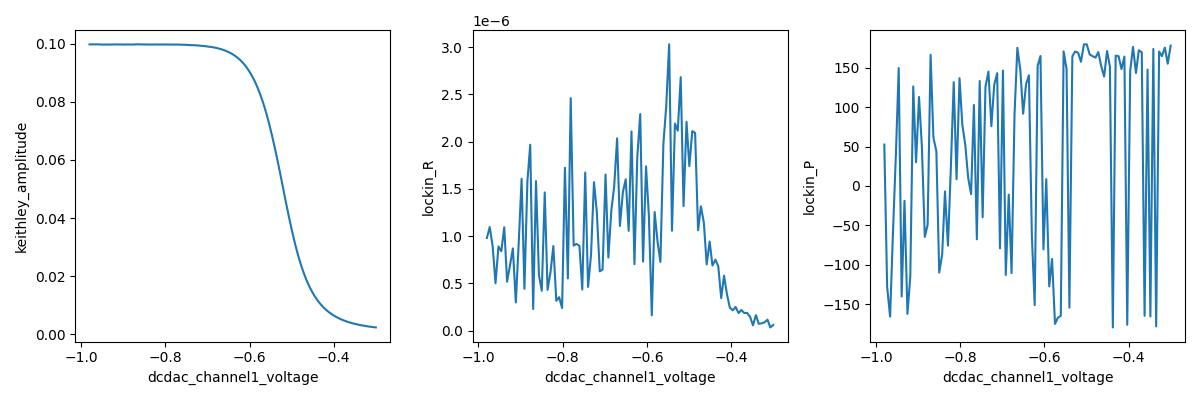

2025-03-21 17:42:44,481 [INFO] Completed in 0h 0m 58s
2025-03-21 17:42:44,482 [INFO] Data saved in C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\Data\data2\38\data.tsv.gz


In [49]:
START = -0.3
STOP = -0.98
SAMPLES = 100
INT_TIME = 0.5

setpoints = np.linspace(START, STOP, SAMPLES)
res = s.sweep(Vgamp,setpoints, delay=INT_TIME)

forgot to add resistor to Vgamp to ensure minimum resistance

In [50]:
sys_paramp()

Ramping down Vgamp ...
Ramping down ac voltages ...
Ramping down Vdd and Vgres ...
System shut down


trying again

In [51]:
Vlref.voltage(400)
V1pf.voltage(100)
Vref.voltage(0)

In [53]:
Vdd(0.1)

seeing 1mV on keithley (Vds dc), so HEMT_A resistance is noticeable

In [54]:
Vgres(-0.5)

In [55]:
Vgamp(-0.4)

In [56]:
Vgres(-1)

In [58]:
indep_params= [Vgamp]
dep_params = [Vdsdc,Vdsac_R, Vdsac_P]

mc = {}
for param in indep_params + dep_params:
    mc[param.full_name] = param.label

s = sweep.Station(basedir=DATA2_PATH,measurement_config=mc)
for param in indep_params + dep_params:
    s.fp(param)

s.add_comment("Vg sweep")

for dep in dep_params:
    s.plot(Vgamp, dep)

2025-03-21 17:50:51,067 [INFO] Starting sweep with ID 39
2025-03-21 17:50:51,070 [INFO] Minimum duration 0h 0m 50s


  0%|          | 0/100 [00:00<?, ?it/s]

2025-03-21 17:51:13,047 [WARNING] ID 39 INTERRUPTED


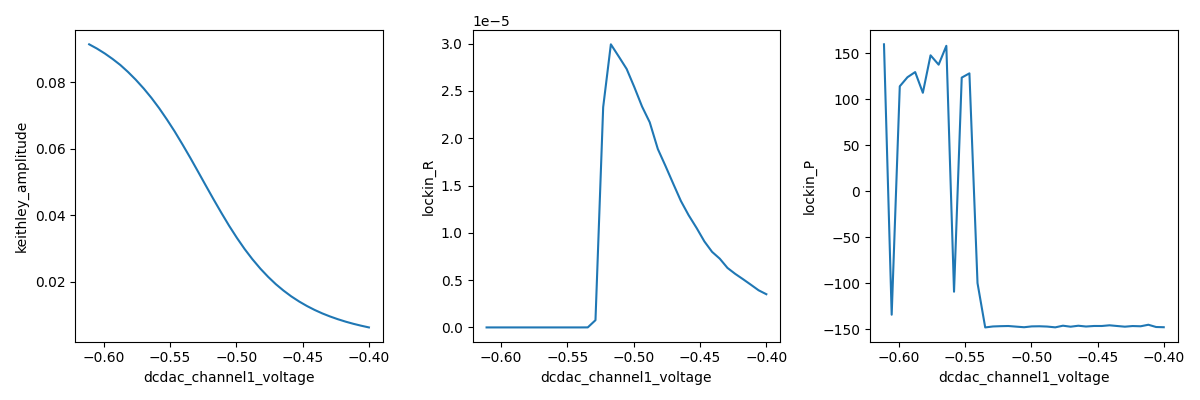

2025-03-21 17:51:13,364 [INFO] Completed in 0h 0m 21s
2025-03-21 17:51:13,365 [INFO] Data saved in C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\Data\data2\39\data.tsv.gz


In [59]:
START = -0.4
STOP = -0.98
SAMPLES = 100
INT_TIME = 0.5

setpoints = np.linspace(START, STOP, SAMPLES)
res = s.sweep(Vgamp,setpoints, delay=INT_TIME)

li overloaded. Increased input range

In [65]:
s = biasStationFactory(comment="Vg sweep")

2025-03-21 17:53:34,836 [INFO] Starting sweep with ID 40
2025-03-21 17:53:34,837 [INFO] Minimum duration 0h 0m 50s


  0%|          | 0/100 [00:00<?, ?it/s]

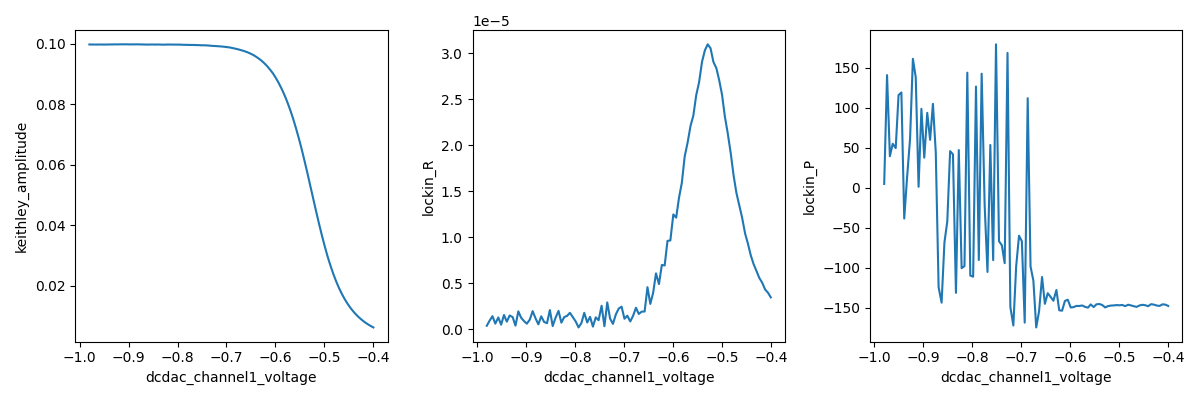

2025-03-21 17:54:33,890 [INFO] Completed in 0h 0m 58s
2025-03-21 17:54:33,890 [INFO] Data saved in C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\Data\data2\40\data.tsv.gz


In [66]:
START = -0.4
STOP = -0.98
SAMPLES = 100
INT_TIME = 0.5

setpoints = np.linspace(START, STOP, SAMPLES)
res = s.sweep(Vgamp,setpoints, delay=INT_TIME)

bias point has shifted to lower voltages? just because of new frequency? 
li was on DC coupling. Switched to AC. 

2025-03-21 17:55:53,792 [INFO] Starting sweep with ID 41
2025-03-21 17:55:53,793 [INFO] Minimum duration 0h 0m 50s


  0%|          | 0/100 [00:00<?, ?it/s]

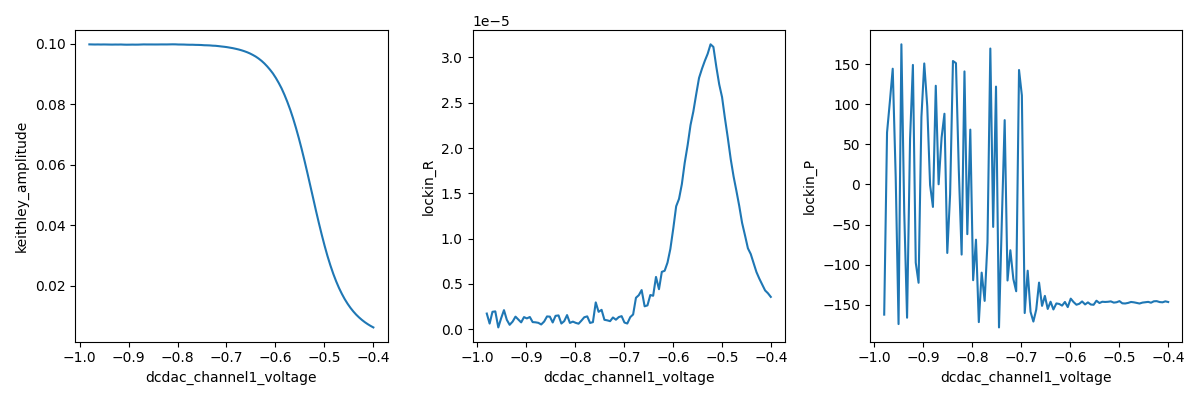

2025-03-21 17:56:52,850 [INFO] Completed in 0h 0m 58s
2025-03-21 17:56:52,851 [INFO] Data saved in C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\Data\data2\41\data.tsv.gz


In [67]:
START = -0.4
STOP = -0.98
SAMPLES = 100
INT_TIME = 0.5

setpoints = np.linspace(START, STOP, SAMPLES)
res = s.sweep(Vgamp,setpoints, delay=INT_TIME)

2 MOhm resistor on Vgamp (DCDAC CH1)

2025-03-21 18:05:52,507 [INFO] Starting sweep with ID 42
2025-03-21 18:05:52,509 [INFO] Minimum duration 0h 0m 50s


  0%|          | 0/100 [00:00<?, ?it/s]

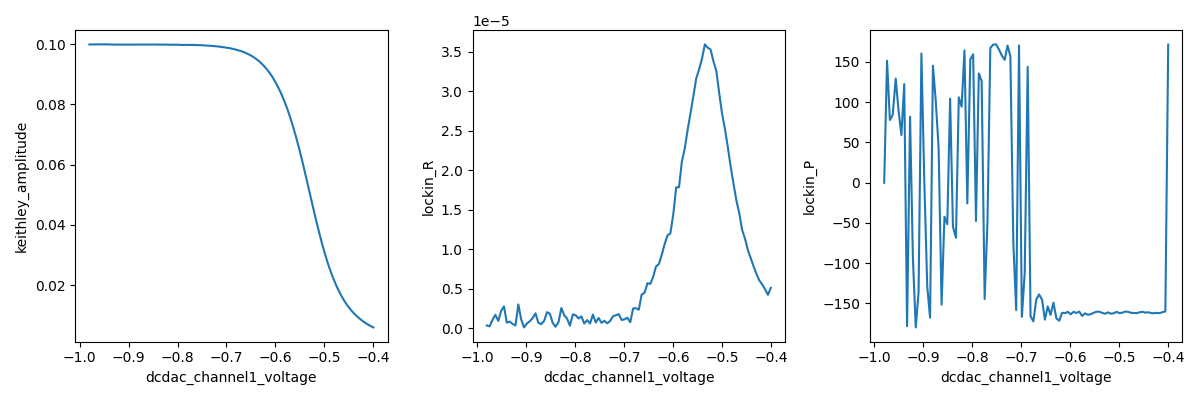

2025-03-21 18:06:51,118 [INFO] Completed in 0h 0m 58s
2025-03-21 18:06:51,119 [INFO] Data saved in C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\Data\data2\42\data.tsv.gz


In [68]:
START = -0.4
STOP = -0.98
SAMPLES = 100
INT_TIME = 0.5

setpoints = np.linspace(START, STOP, SAMPLES)
res = s.sweep(Vgamp,setpoints, delay=INT_TIME)

2025-03-21 18:07:04,477 [INFO] Starting sweep with ID 43
2025-03-21 18:07:04,478 [INFO] Minimum duration 0h 0m 50s


  0%|          | 0/100 [00:00<?, ?it/s]

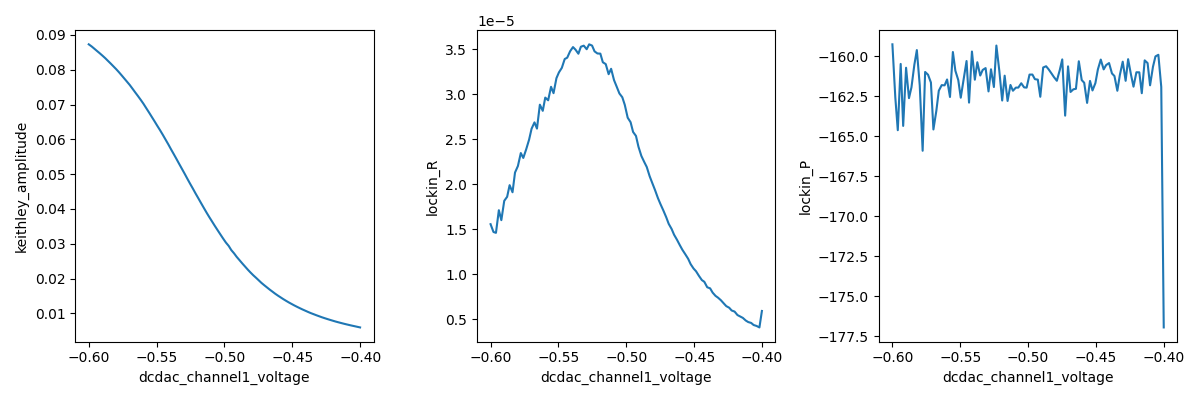

2025-03-21 18:08:03,032 [INFO] Completed in 0h 0m 58s
2025-03-21 18:08:03,032 [INFO] Data saved in C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\Data\data2\43\data.tsv.gz


In [69]:
START = -0.4
STOP = -0.6
SAMPLES = 100
INT_TIME = 0.5

setpoints = np.linspace(START, STOP, SAMPLES)
res = s.sweep(Vgamp,setpoints, delay=INT_TIME)

In [79]:
res.id

43

In [19]:
from sweep.sweep_load import pload1d 
import matplotlib.pyplot as plt

bias_data = pload1d(DATA2_PATH, 43)
bias_data.keys()

dict_keys(['measurement_config', 'xs', 'time', 'dcdac_channel1_voltage', 'keithley_amplitude', 'lockin_R', 'lockin_P'])

In [20]:
Vgamp.full_name

'dcdac_channel1_voltage'

In [23]:
idx_max = np.argmax(bias_data[Vdsac_R.full_name])
idx_max

np.int64(63)

In [24]:
plt.plot(bias_data[Vgamp.full_name], bias_data[Vdsac_R.full_name])
plt.show()

In [25]:
BIAS_POINT = bias_data[Vgamp.full_name][idx_max]

In [26]:
BIAS_POINT

np.float64(-0.52736)

BIAS_POINT = -0.52736V with Vgres at -1.0V and 2MOhm resistor on HEMT_A gate

Gain seems lower than before. Suspect AC leakage through Vgamp line because of lower resistor values

## Watching Noise

### Helpers

In [ ]:
def print_lockin_props():
    tau = li1.time_constant()
    sens = li1.sensitivity()
    irange = li1.input_range()
    filter_slope = li1.filter_slope()
    coupling = li1.input_coupling()
    freq = li1.frequency()
    enbw = li1.noise_bandwidth()

    props = {
        "tau": tau,
        "sens": sens,
        "irange": irange,
        "filter_slope": filter_slope,
        "coupling": coupling,
        "freq": freq,
        "enbw": enbw
    }
    
    return props

class Xnoise():
    def __init__(self):
        self.full_name = "x_noise"
        
    def __call__(self):
        return float(li1.ask("OUTP? 8"))
    
class Ynoise():
    def __init__(self):
        self.full_name = "y_noise"
        
    def __call__(self):
        return float(li1.ask("OUTP? 9"))

In [45]:
print_lockin_props()

{'tau': 0.1,
 'sens': 1e-05,
 'irange': 0.01,
 'filter_slope': 12,
 'coupling': 'ac',
 'freq': 996.47949219,
 'enbw': 1.25}

In [46]:
xn = Xnoise()
yn = Ynoise()

xn(), yn()

(3.1762490948e-07, 3.2645419878e-07)

In [48]:
def watchStationFactory(comment="noise monitoring"):
    s = sweep.Station()
    s.add_comment(comment)
    deps = [li1.X, li1.Y, xn,  yn]

    for param in deps:
        s.fp(param)
        s.plot("time", param)

    return s 

### Biasing

In [35]:
BIAS_POINT = -0.52736

In [27]:
Vlref.voltage(400)
V1pf.voltage(100)
Vref.voltage(0)

In [28]:
Vdd(0.1)

In [32]:
Vgres.remove_validator()
Vgres.validators

()

In [34]:
Vgres(-0.5)

In [36]:
Vgamp(-0.4)

In [37]:
Vgres(-1.0)

In [38]:
Vgamp(BIAS_POINT)

### Watching

Zeroing out AC voltages (apart from lockin reference) and Vdd to measure noise at bias point. Vgres and Vgamp stay at -1 and -0.52736 volts

In [39]:
V1pf.voltage(0)

In [40]:
Vdd(0)

In [41]:
Vgres(), Vgamp(), Vdd()

(-1.0, -0.52736, 0.0)

In [42]:
acdac.print_readable_snapshot()

acdac:
	parameter   value
--------------------------------------------------------------------------------
IDN          :	{'vendor': 'BARRERA', 'model': 'ACDAC02', 'serial': 'AD9106', ...
display_mode :	NORMAL 
 rror        :	0 - No Error
frequency    :	1000 (Hz)
timeout      :	5 (s)
acdac_ch1:
	parameter value
--------------------------------------------------------------------------------
phase   :	0 (deg)
voltage :	0 (mV)
acdac_ch2:
	parameter value
--------------------------------------------------------------------------------
phase   :	0 (deg)
voltage :	0 (mV)
acdac_ch3:
	parameter value
--------------------------------------------------------------------------------
phase   :	0 (deg)
voltage :	0 (mV)
acdac_ch4:
	parameter value
--------------------------------------------------------------------------------
phase   :	0 (deg)
voltage :	400 (mV)


keep li ac coupled or not? don't want to see contribution from biasing voltages so keep ac coupled. 

Lowered li sensitivity and input range to lowest settings without overloading. 

In [49]:
s = watchStationFactory("noise trial 1")

In [50]:
li_props = print_lockin_props()
li_props

{'tau': 0.1,
 'sens': 5e-06,
 'irange': 0.01,
 'filter_slope': 12,
 'coupling': 'ac',
 'freq': 996.51239014,
 'enbw': 1.25}

In [51]:
delay = 2 * li_props["tau"]

In [53]:
s.read_all()

2025-03-21 18:42:50,094 [INFO] Reading all parameters:
2025-03-21 18:42:50,105 [INFO] Reading lockin_X: -2.7962065019e-07
2025-03-21 18:42:50,115 [INFO] Reading lockin_Y: 9.584201166e-08
2025-03-21 18:42:50,135 [INFO] Reading x_noise: 3.2491681168e-07
2025-03-21 18:42:50,150 [INFO] Reading y_noise: 3.0087136338e-07


2025-03-21 18:42:58,829 [INFO] Starting watch with ID 44


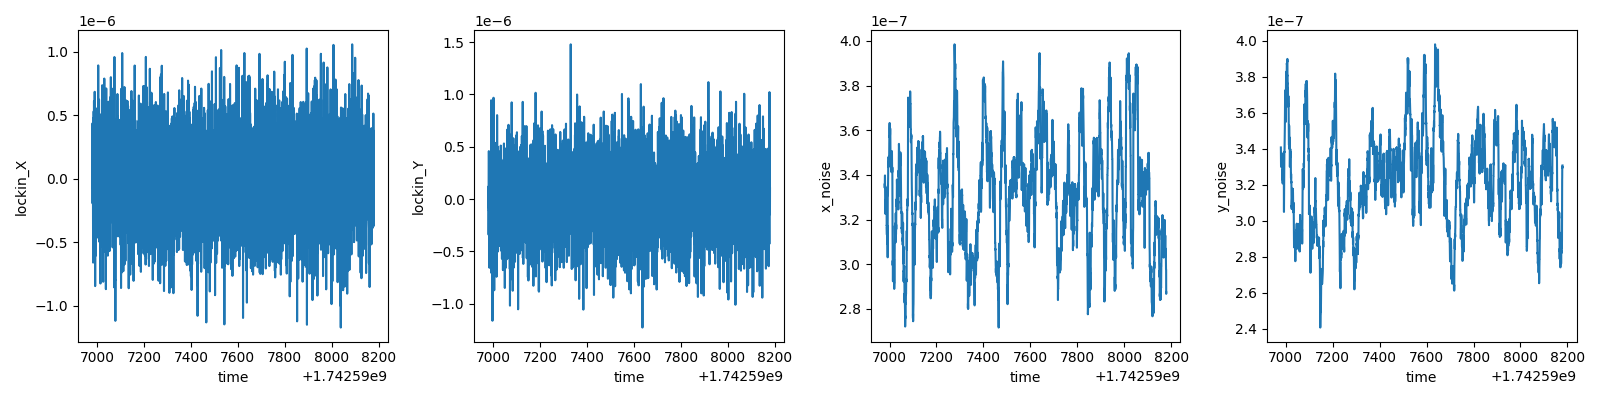

2025-03-21 19:02:59,728 [INFO] Completed in 0h 20m 0s
2025-03-21 19:02:59,729 [INFO] Data saved in C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\Data\data2\44\data.tsv.gz


In [54]:
s.watch(delay=delay, max_duration=1200)

In [71]:
sys_paramp()

Ramping down Vgamp ...
Ramping down ac voltages ...
Ramping down Vdd and Vgres ...
System shut down


# Analysis

In [55]:
from sweep.sweep_load import pload1d 
import matplotlib.pyplot as plt 
%matplotlib inline 

from matplotlib import rc
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 14}
rc('font', **font)

In [60]:
def stats(A):
    mu = np.mean(A)
    std = np.std(A) 
    return mu, std 

In [56]:
print_lockin_props()

{'tau': 0.1,
 'sens': 5e-06,
 'irange': 0.01,
 'filter_slope': 12,
 'coupling': 'ac',
 'freq': 996.50024414,
 'enbw': 1.25}

In [68]:
enbw = 1.25

In [59]:
res = pload1d(DATA2_PATH, 44)
liX = res[li1.X.full_name].copy()
liY = res[li1.Y.full_name].copy()
liXn = res[xn.full_name].copy()
liYn = res[yn.full_name].copy()


#convert to micro volts
liX *= 1e6
liY *= 1e6
liXn *= 1e6
liYn *= 1e6

t = res["time"].copy()
t -= t[0]
t /= 60 

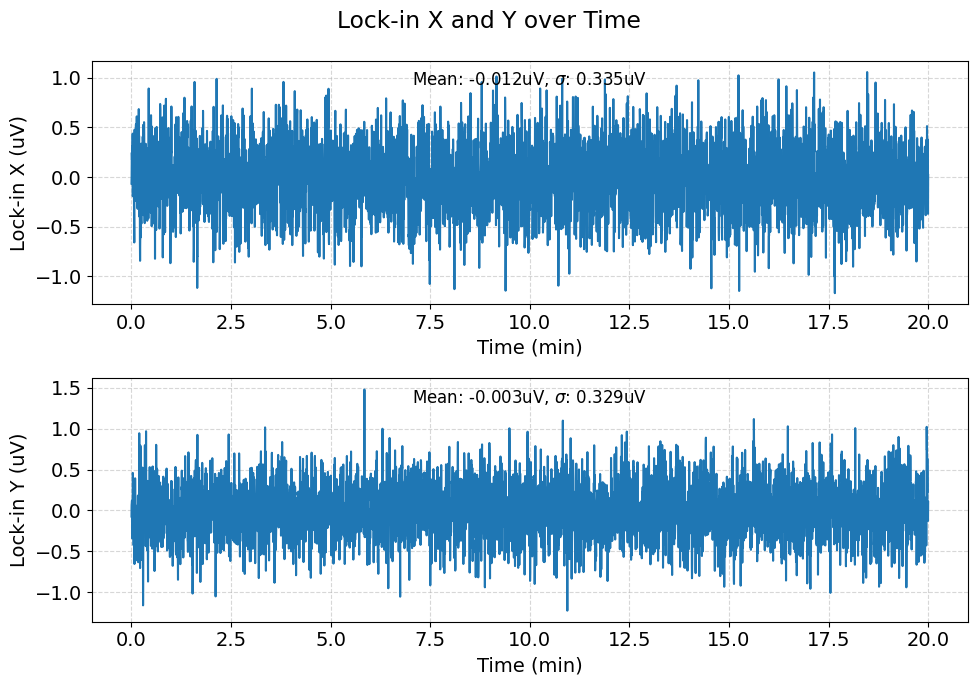

In [62]:
muX, stdX = stats(liX)
muY, stdY = stats(liY)

fig, ax = plt.subplots(2, 1, figsize=(10, 7))


fig.suptitle("Lock-in X and Y over Time")

ax[0].text(0.5, 0.90, rf"Mean: {muX:.3f}uV, $\sigma$: {stdX:.3f}uV", ha='center', transform=ax[0].transAxes, fontsize=12)
ax[1].text(0.5, 0.90, rf"Mean: {muY:.3f}uV, $\sigma$: {stdY:.3f}uV", ha='center', transform=ax[1].transAxes, fontsize=12)

# ax[0].set_title(rf"Mean: {muX:.3f}uV, $\sigma$: {stdX:.3f}uV")
ax[0].plot(t, liX)
ax[0].set_xlabel("Time (min)")
ax[0].set_ylabel(r"Lock-in X (uV)")

# ax[1].set_title(rf"Mean: {muY:.3f}uV, $\sigma$: {stdY:.3f}uV")
ax[1].plot(t, liY)
ax[1].set_xlabel("Time (min)")
ax[1].set_ylabel(r"Lock-in Y (uV)")

ax[0].grid(True, linestyle='--', alpha=0.5)
ax[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [63]:
muXn, stdXn = stats(liXn)
muYn, stdYn = stats(liYn)

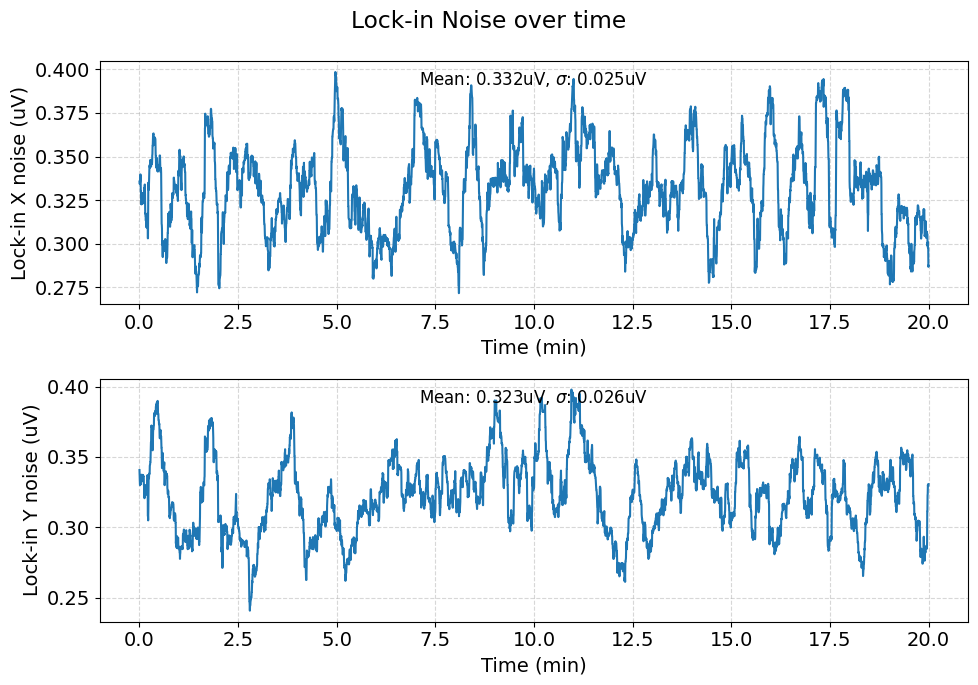

In [65]:
fig, ax = plt.subplots(2, 1, figsize=(10, 7))

fig.suptitle("Lock-in Noise over time")

ax[0].text(0.5, 0.90, rf"Mean: {muXn:.3f}uV, $\sigma$: {stdXn:.3f}uV", ha='center', transform=ax[0].transAxes, fontsize=12)
ax[1].text(0.5, 0.90, rf"Mean: {muYn:.3f}uV, $\sigma$: {stdYn:.3f}uV", ha='center', transform=ax[1].transAxes, fontsize=12)

ax[0].plot(t, liXn)
ax[0].set_xlabel("Time (min)")
ax[0].set_ylabel(r"Lock-in X noise (uV)")

ax[1].plot(t, liYn)
ax[1].set_xlabel("Time (min)")
ax[1].set_ylabel(r"Lock-in Y noise (uV)")

ax[0].grid(True, linestyle='--', alpha=0.5)
ax[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [66]:
muXnu = stdXn/np.sqrt(len(liXn))
muYnu = stdYn/np.sqrt(len(liYn))
print(muXnu, muYnu)

0.0003618943795454734 0.00038008394680986513


In [69]:
iXnoise, iXnoiseU = muXn/np.sqrt(enbw), muXnu/np.sqrt(enbw)
iYnoise, iYnoiseU = muYn/np.sqrt(enbw), muYnu/np.sqrt(enbw) 

In [70]:
inoise = (iXnoise + iYnoise)/2
inoiseU = np.sqrt(iXnoiseU**2 + iYnoiseU**2)/2
print(inoise, inoiseU)

0.29282256089949765 0.00023470464357109238


10x higher noise level
292.8 +/- 0.2 nV/sqrt(Hz)

In [75]:
li1.noise_bandwidth()

1.25